# Calling Object Detection model from Docker

In [1]:
import cv2
import datetime
import docker
import matplotlib.pyplot as plt 
import os
import requests
import sys
import time

from PIL import Image

In [2]:
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 09-Apr-2025 11:26:03


## Docker

In [4]:
docker_model_endpoint = "http://127.0.0.1:80/image"

In [5]:
try:
    response = requests.get("http://127.0.0.1:80")
    respcode = response.status_code
    if respcode == 200:
        print(f"OK. Status code = {respcode}")
    else:
        print(f"Failed to get status. Status code: {respcode}")

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

OK. Status code = 200


In [6]:
docker_client = docker.from_env()
docker_client

In [7]:
print("Active Docker container(s):\n")

for idx2, container in enumerate(docker_client.containers.list(), start=1):
    print(f"{idx2} - Docker container name: {container.name}")
    print(f"Container image: {container.image}")
    print(f"Container id: {container.id}\n")

Active Docker container(s):

1 - Docker container name: ollama
Container image: <Image: 'ollama/ollama:latest'>
Container id: 257159622cffe0d0c91d56b85c8e63cfe28fb540683427a2945ea1279a6077a1

2 - Docker container name: trusting_meninsky
Container image: <Image: 'swimmingpools:latest'>
Container id: a581d318ab044980c3d6825b256dad30cf0c2db54a52ddf1e22385efc70e1593



In [8]:
print("List of all the Docker container images:\n")

for idx, image in enumerate(docker_client.images.list(), start=1):
    print(f"{idx} - Docker container image: {image}")
    print(f"Image id: {image.id}\n")

print(f"Total number of docker container images = {idx}")

List of all the Docker container images:

1 - Docker container image: <Image: 'swimmingpools:latest'>
Image id: sha256:cb83fd9848cd8afbd0ccd547b110be52d0e4557924c011b716aeaf4a1bd33534

2 - Docker container image: <Image: 'damageclassification:latest'>
Image id: sha256:b50e4ee1faa9b73f33bc6e0f5952a222bdc1b4334ece7956cd75d8efa8731cc2

3 - Docker container image: <Image: 'ollama/ollama:latest'>
Image id: sha256:96b7667cb536ab69bfd5cc0c2bd1e29602218e076fe6d34f402b786f17b4fde0

4 - Docker container image: <Image: 'mcr.microsoft.com/azure-cognitive-services/form-recognizer/layout-4.0:2024-11-30'>
Image id: sha256:bec17568a31b01a7e45af56d150bee91a6da28e37d51907d31330e92555f4f6e

5 - Docker container image: <Image: 'mcr.microsoft.com/azure-cognitive-services/textanalytics/summarization:cpu'>
Image id: sha256:7b62d8976c582a3c5b99f670851bcfb60d2f648969f2aa3035ee159b2841adb5

6 - Docker container image: <Image: 'mcr.microsoft.com/azure-cognitive-services/form-recognizer/read-3.1:latest'>
Image id

## Function

In [9]:
def display_image(filename):
    """
    Displays an image using Matplotlib.

    Args:
        filename (str): The path to the image file.

    This function reads an image from the specified file, converts its color
    from BGR to RGB, and displays it using Matplotlib. The displayed image
    has no axis and is shown in a 10x10 inch figure.
    """
    img = cv2.imread(filename)

    if img is None:
        raise FileNotFoundError(f"File {filename} not found.")

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image_rgb)
    plt.show()

In [10]:
def display_both_images(img1, img2):
    """
    Displays two images side by side using Matplotlib and saves the combined image.

    Args:
        img1 (str): The path to the first image file.
        img2 (str): The path to the second image file.

    This function reads two images from the specified files, displays them side by side
    in a single figure, and saves the combined image to a new file. The titles for the
    images and the figure are set to indicate the initial image and the detections with
    Azure Custom Vision.
    """
    image1 = plt.imread(img1)
    image2 = plt.imread(img2)

    if image1 is None:
        raise FileNotFoundError(f"File {img1} not found.")
    if image2 is None:
        raise FileNotFoundError(f"File {img2} not found.")

    fig, ax = plt.subplots(1, 2, figsize=(15, 9))
    ax[0].imshow(image1)
    ax[1].imshow(image2)

    ax[0].set_title(f'Initial image:\n{img1}')
    ax[1].set_title(f'Detections with Azure Custom Vision:\n{img2}')

    fig.suptitle('Swimming pool detection with Azure Custom Vision',
                 fontsize=15)
    plt.tight_layout()

    export_image = os.path.splitext(img1)[0] + '_both.jpg'
    plt.savefig(export_image)
    plt.show()

In [11]:
def get_objectdetection_results(minconfidence, inputimagefile):
    """
    Calls the Azure Custom Vision model to detect swimming pools in an image and saves the result.

    Args:
        minconfidence (float): The minimum confidence threshold for detections.
        inputimagefile (str): The path to the input image file.
        outputimagefile (str): The path to save the output image file with detections.

    This function reads an image from the specified file, calls the Azure Custom Vision model to detect
    swimming pools, and draws bounding boxes around detected pools with confidence scores. The results
    are printed to the console, and the output image with detections is saved to a new file.
    """
    print("Calling Azure Custom Vision model...")
    nb = 0

    # Color settings
    colors = {
        'green': (0, 255, 0),
        'lime': (50, 205, 50),
        'yellow': (0, 215, 255),
        'cyan': (255, 255, 0),
        'red': (0, 0, 255),
        'black': (0, 0, 0),
        'white': (255, 255, 255),
        'blue': (139, 0, 0),
        'pink': (133, 21, 199)
    }

    # Other settings
    settings = {
        'rectsize': 2,
        'fontsize1': 0.4,
        'fontsize2': 0.8,
        'fontsize3': 0.6,
        'fontsize4': 0.4,
        'thickness1': 1,
        'thicknesscircle': 2,
        'thickness2': 1,
        'thickness3': 2,
        'radius': 3,
        'offset': 5,
        'font1': cv2.FONT_HERSHEY_TRIPLEX,
        'font2': cv2.FONT_HERSHEY_SIMPLEX
    }

    # Reading image file and get predictions
    headers = {"Content-Type": "application/octet-stream"}

    with open(test_image, "rb") as image_data:
        response = requests.post(docker_model_endpoint,
                                 headers=headers,
                                 data=image_data)

    # Parsing
    predictions = response.json()['predictions']

    image = cv2.imread(inputimagefile)
    if image is None:
        raise FileNotFoundError(f"File {inputimagefile} not found.")

    h, w = image.shape[:2]
    print('\033[1;31;34m\nAzure Custom Vision model results:\n')

    # Results
    for prediction in predictions:
        if prediction["probability"] >= minconfidence and prediction[
                "tagName"] == 'pool':
            nb += 1
            bbox = prediction["boundingBox"]
            score = prediction["probability"]

            x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
            x2, y2 = int((bbox["left"] + bbox["width"]) * w), int(
                (bbox["top"] + bbox["height"]) * h)
            xcenter, ycenter = (x1 + x2) // 2, (y1 + y2) // 2
            surface = (x2 - x1) * (y2 - y1)

            # Printing results
            print(
                f"{nb}\tswimming pool detected with confidence = {round(score, 4)}"
            )
            print(f"\tBounding Box: [{x1}, {y1}, {x2}, {y2}]")
            print(f"\tApproximated surface = {surface}\n")

            # Drawing bounding box
            result_image = cv2.rectangle(image, (x1, y1), (x2, y2),
                                         colors['lime'], settings['rectsize'])
            msg1 = f"{nb} [{round(score, 2)}]"
            cv2.rectangle(result_image, (x1 - 10, y1 - 20), (x1 + 48, y1 + 3),
                          colors['blue'],
                          thickness=-1)
            cv2.putText(result_image, msg1,
                        (x1 - settings['offset'], y1 - settings['offset']),
                        settings['font2'], settings['fontsize1'],
                        colors['white'], settings['thickness2'], cv2.LINE_AA)
            cv2.circle(result_image, (xcenter, ycenter), settings['radius'],
                       colors['red'], settings['thicknesscircle'])

    # Additional messages
    msg2 = f"{nb} swimming pools"
    cv2.rectangle(result_image, (10, 5), (260, 25),
                  colors['black'],
                  thickness=-1)
    cv2.putText(result_image, msg2, (20, 20), settings['font2'],
                settings['fontsize2'], colors['white'], settings['thickness2'],
                cv2.LINE_AA)

    msg3 = "Powered by Azure Custom Vision"
    cv2.putText(result_image, msg3, (20, h - 20), settings['font2'],
                settings['fontsize4'], colors['cyan'], settings['thickness2'],
                cv2.LINE_AA)

    # Export image
    output_imagefile = os.path.splitext(test_image)[0] + '_predict.jpg'
    cv2.imwrite(output_imagefile, result_image,
                [int(cv2.IMWRITE_JPEG_QUALITY), 100])

    print(f"Total number of swimming pools detected in the image = {nb}")

    return output_imagefile, nb, predictions

## Testing

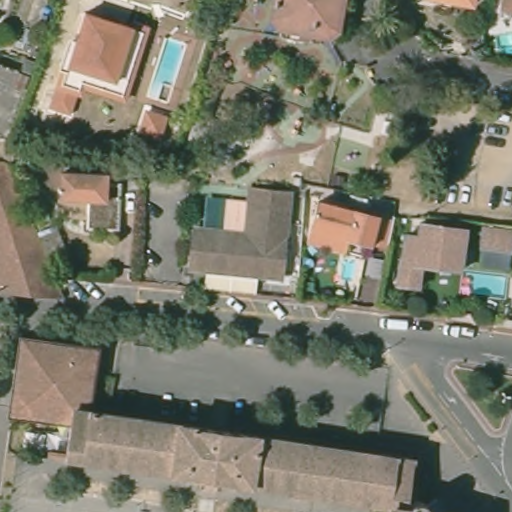

In [12]:
test_image = "images/test1.jpg"

img = Image.open(test_image)
img

In [13]:
start = time.time()
output_imagefile, nb, predictions = get_objectdetection_results(0.5, test_image)

elapsed = time.time() - start
print(f"\nCompleted in {elapsed:.05} secs")

Calling Azure Custom Vision model...

Azure Custom Vision model results:

1	swimming pool detected with confidence = 1.0
	Bounding Box: [149, 34, 189, 99]
	Approximated surface = 2600

2	swimming pool detected with confidence = 0.9991
	Bounding Box: [492, 29, 511, 53]
	Approximated surface = 456

3	swimming pool detected with confidence = 0.9988
	Bounding Box: [457, 268, 512, 302]
	Approximated surface = 1870

4	swimming pool detected with confidence = 0.9931
	Bounding Box: [337, 253, 361, 282]
	Approximated surface = 696

Total number of swimming pools detected in the image = 4

Completed in 0.071042 secs


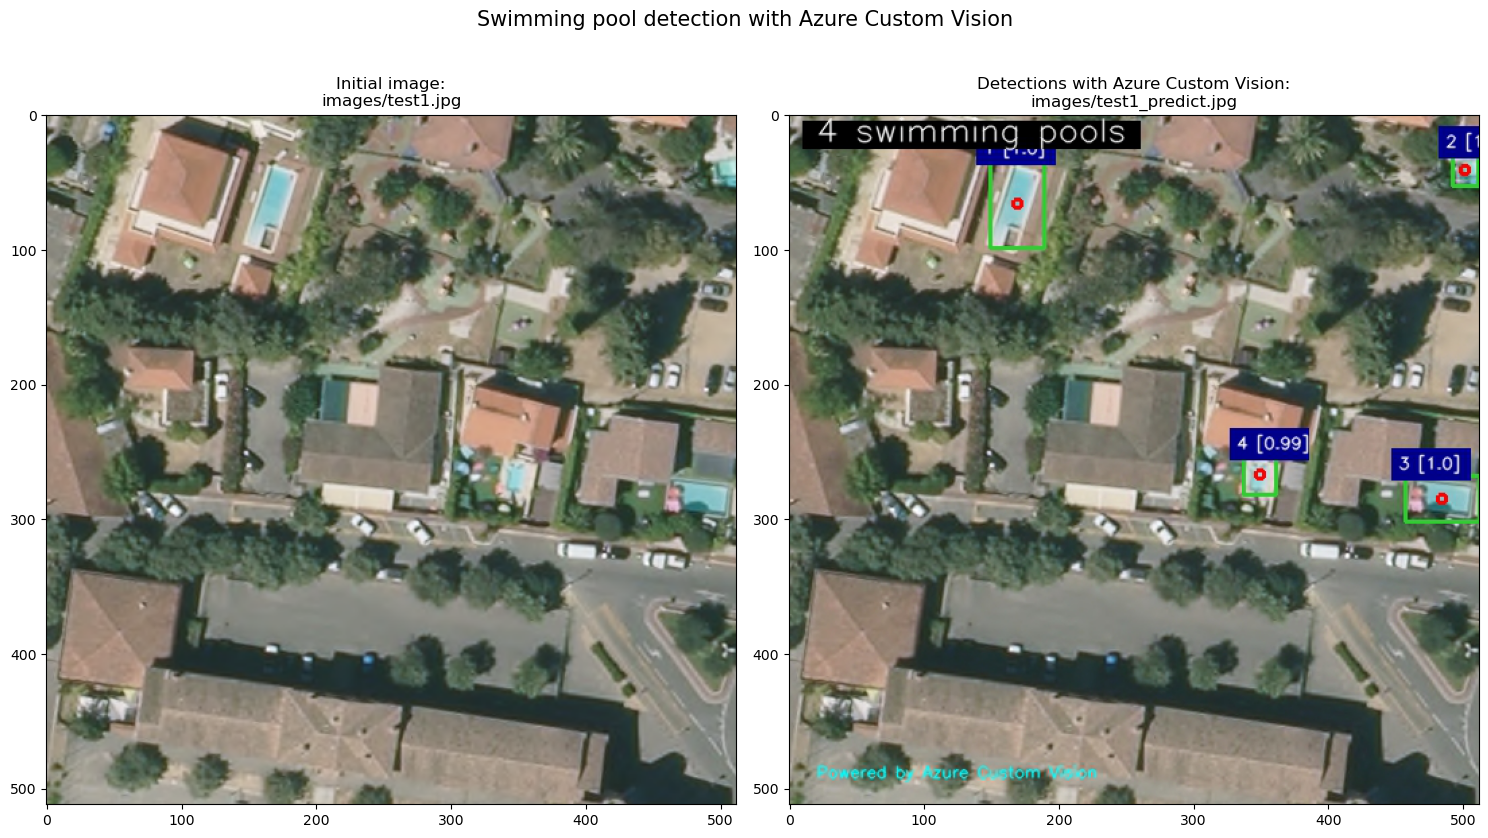

In [14]:
display_both_images(test_image, output_imagefile)

In [15]:
nb

4

In [16]:
predictions

[{'boundingBox': {'height': 0.12696499,
   'left': 0.29223132,
   'top': 0.0675808,
   'width': 0.07697695},
  'probability': 0.99999982,
  'tagId': 0,
  'tagName': 'pool'},
 {'boundingBox': {'height': 0.04564708,
   'left': 0.96127725,
   'top': 0.05788725,
   'width': 0.03868902},
  'probability': 0.99912864,
  'tagId': 0,
  'tagName': 'pool'},
 {'boundingBox': {'height': 0.06697249,
   'left': 0.89296752,
   'top': 0.52360755,
   'width': 0.10725385},
  'probability': 0.99884623,
  'tagId': 0,
  'tagName': 'pool'},
 {'boundingBox': {'height': 0.0562329,
   'left': 0.65911198,
   'top': 0.49526033,
   'width': 0.04694808},
  'probability': 0.99308109,
  'tagId': 0,
  'tagName': 'pool'},
 {'boundingBox': {'height': 0.04218981,
   'left': 0.01529341,
   'top': 0.01402987,
   'width': 0.02554905},
  'probability': 1.056e-05,
  'tagId': 0,
  'tagName': 'pool'},
 {'boundingBox': {'height': 0.04218981,
   'left': 0.01529341,
   'top': 0.01402987,
   'width': 0.02554905},
  'probability': 1